##EARLY DETECTION OF BREAST CANCER USING CONVOLUTIONAL NEURAL NETWORK


Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

The goal of this script is to identify IDC when it is present in otherwise unlabeled histopathology images. The dataset consists of approximately five thousand 50x50 pixel RGB digital images of H&E-stained breast histopathology samples that are labeled as either IDC or non-IDC. These numpy arrays are small patches that were extracted from digital images of breast tissue samples. The breast tissue contains many cells but only some of them are cancerous. Patches that are labeled "1" contain cells that are characteristic of invasive ductal carcinoma.

- Importing Dataset
- Basic EDA 
- DATA AUGUMENTATION
- CLASSIFICATION


#LOADING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import os
import itertools
import glob as glob
import fnmatch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,make_scorer,accuracy_score
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold,learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

import keras
from keras import backend as k
from keras.callbacks import History
from keras_preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json

from keras.layers import Dense, Dropout,Activation, Flatten,BatchNormalization, Conv2D, MaxPool2D ,MaxPooling2D
import tensorflow as tf

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 14.7 MB/s 


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


## IMPORTING DATASET


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [ ]:
DataDir ='C:/Users/Sarah Yeboah Manu/Desktop/cancerimages'

In [ ]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.7_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 154 kB 14.3 MB/s 
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31646 sha256=aba6e33ad1303b6eed600bdc59d1e7d6ac8105db745255e76e70e02e8fca9318
  Stored in directory: /root/.cache/pip/wheels/63/b1/c6/b3da79bec2012175bd43603eed98ef8548ac1733b77c1d4330
Successfully built libarchive


In [ ]:
from zipfile import ZipFile
file_name = "datazip.zip"
with ZipFile(file_name, "r") as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
import pathlib
X= np.load("/content/X.npy")
Y= np.load("/content/Y.npy")

In [ ]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


In [ ]:
print('X.shape =', X.shape)
print('X.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X.min(),
                        X.mean(), X.std(), X.max()))
print('')
print('Y.shape =', Y.shape)
print('Y.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(Y.min(),
                        Y.mean(), Y.std(), Y.max()))

X.shape = (5547, 50, 50, 3)
X.min/mean/std/max = 2.00/185.03/47.25/255.00

Y.shape = (5547,)
Y.min/mean/std/max = 0.00/0.50/0.50/1.00


#IMAGES FROM THE ORIGINAL DATASET

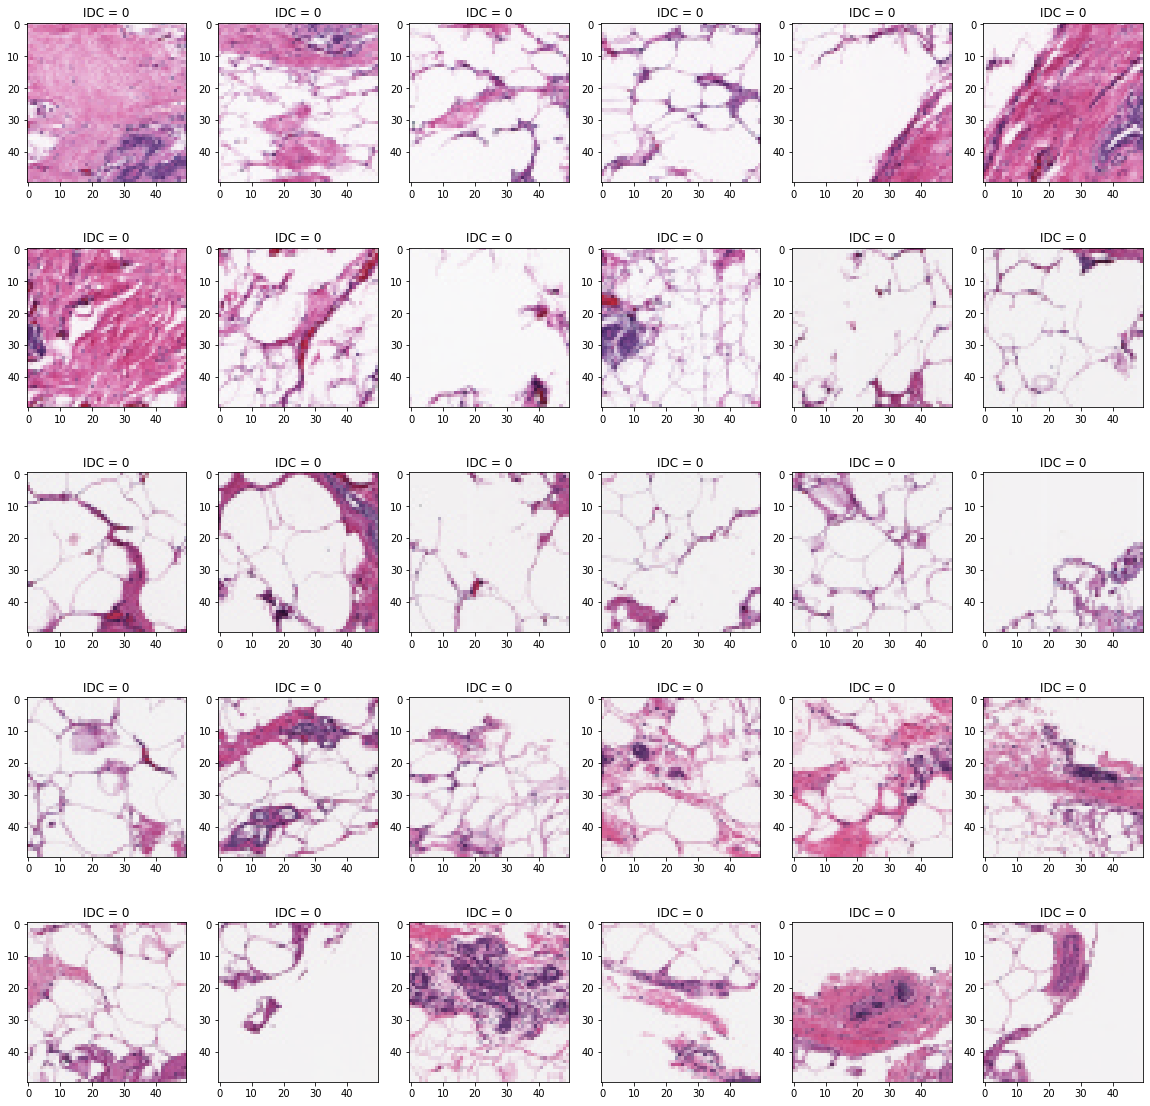

In [ ]:
image0 = X[Y == 0] 
image1 = X[Y == 1] 

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

#Data Analysis(EDA)

In [ ]:
def read_img(img):
 img = cv2.imread(img)
 img = cv2.resize(img, (50,50))
 return img


In [ ]:
image0 = X[Y == 0] 
image1 = X[Y == 1] 

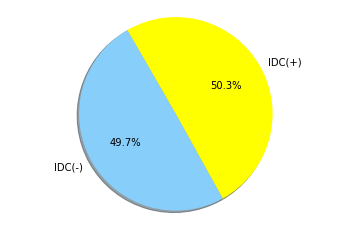

In [ ]:
labels = "IDC(-)", "IDC(+)"
sizes = [len(image0),len(image1)]
colors = ["lightskyblue","yellow"]

#plot
plt.pie(sizes, labels=labels,colors=colors,
        autopct ="%1.1f%%", shadow =True, startangle = 120)
plt.axis("equal")
plt.show()

A graphical Representation of the breast cancer image.
-From the diagram the images recorded to be cancerous is 50.3% and the the non cancerous cell to be 49.7%
- Data Augmentation will be performed on the cancerous image since we want to build a modle which can easily detect cancerous cell in any form 

# DATA AUGMENTATION

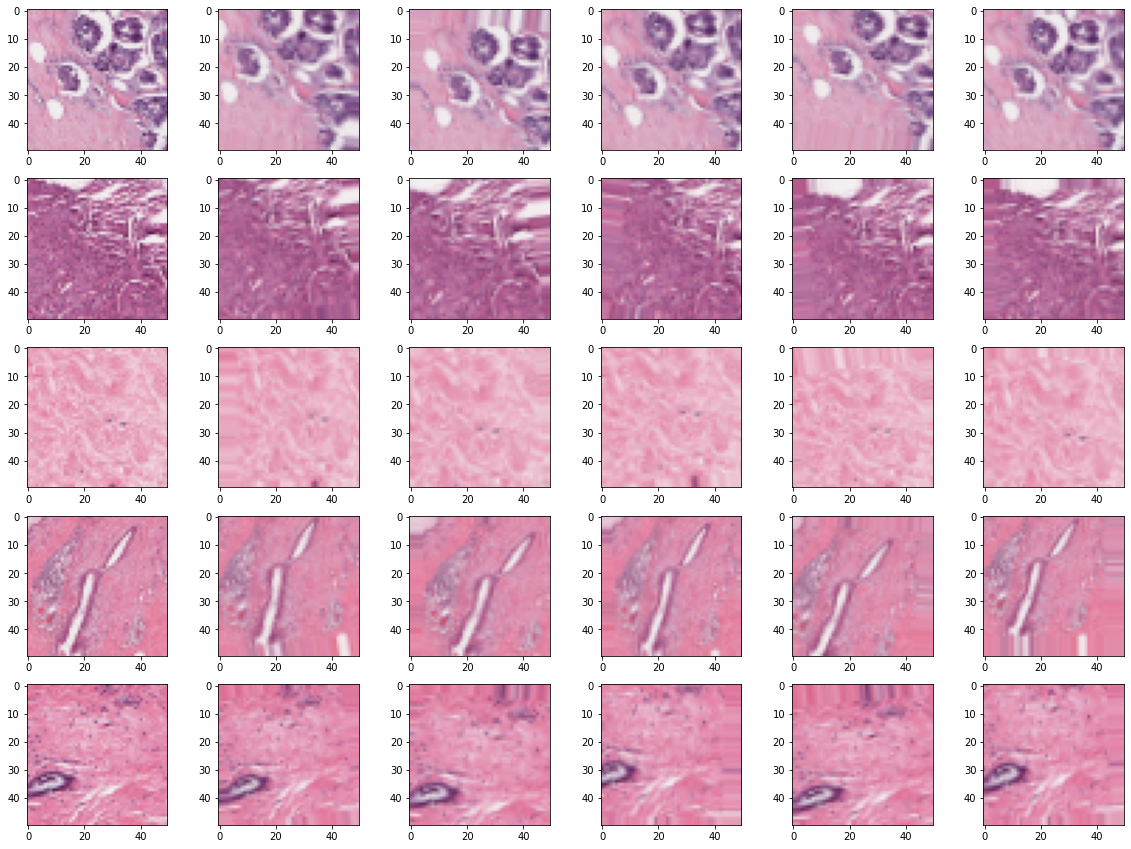

In [ ]:
## augment data
import keras.preprocessing.image
# generate new images via rotations, translations, zoom using keras
def generate_images(imgs):
    
    # rotations, translations, zoom
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        zoom_range = 0.1)

    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()    
    return imgs[0]

# check image generation
fig,axs = plt.subplots(5,6, figsize=(20,15)) # defines the plot area, 5 rows and 6 columns
for i in range(5): #  i that goes from 0 to 4
    n = np.random.randint(0,X.shape[0]-2) # n is a random number between and the size of the dataset -2 (5547-2 = 5545)
    axs[i,0].imshow(X[n])
    axs[i,1].imshow(generate_images(X[n:n+1])[0].astype('uint8'))
    axs[i,2].imshow(generate_images(X[n:n+1])[0].astype('uint8'))
    axs[i,3].imshow(generate_images(X[n:n+1])[0].astype('uint8'))
    axs[i,4].imshow(generate_images(X[n:n+1])[0].astype('uint8'))
    axs[i,5].imshow(generate_images(X[n:n+1])[0].astype('uint8'))

In [ ]:
from tensorflow.keras import layers

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

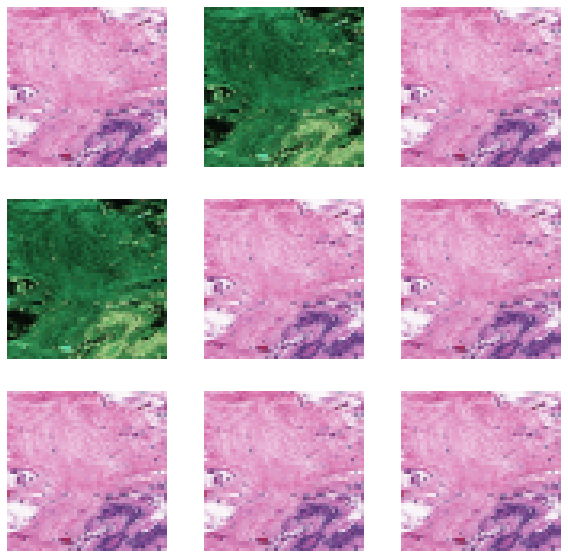

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(X)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

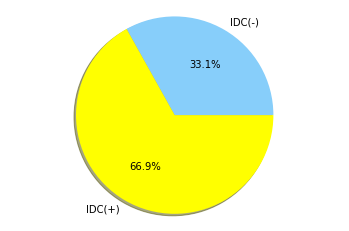

In [ ]:
labels = "IDC(-)", "IDC(+)"
sizes = [len(image0),len(image1)*2]
colors = ["lightskyblue","yellow"]

#plot
plt.pie(sizes, labels=labels,colors=colors,
        autopct ="%1.1f%%", shadow =True, startangle = 360)
plt.axis("equal")
plt.show()

## BUILDING A CLASSIFIER 


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score


In [ ]:
print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

X.shape:  (5547, 50, 50, 3)
Y.shape:  (5547,)


In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, random_state=2)
numberoftrain = xtrain.shape[0]
numberoftest = xtest.shape[0]
print(xtrain.shape)
print(xtest.shape)

(4437, 50, 50, 3)
(1110, 50, 50, 3)


#Splitting the data into training , validation and testing



In [ ]:
from sklearn.model_selection import train_test_split
# since we want o split the dataset into test , training and validation set.
#first take the proportion, training set = 60% , Test set = 20% and the validation set = 20 %
# first split the training set and the remaing set

train_size=0.6
X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=0.6)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(3328, 50, 50, 3)
(3328,)
(1109, 50, 50, 3)
(1109,)
(1110, 50, 50, 3)
(1110,)


(None, None)

In [ ]:
# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test/ 255.0

In [ ]:
y_train

array([0, 1, 1, ..., 0, 1, 1])

In [ ]:
X_train

array([[[[0.94509804, 0.90196078, 0.92941176],
         [0.94901961, 0.91372549, 0.94117647],
         [0.95294118, 0.9372549 , 0.94901961],
         ...,
         [0.94901961, 0.94117647, 0.9372549 ],
         [0.94509804, 0.9254902 , 0.92941176],
         [0.94509804, 0.89019608, 0.9254902 ]],

        [[0.91764706, 0.72156863, 0.79607843],
         [0.94901961, 0.92156863, 0.93333333],
         [0.95686275, 0.94509804, 0.96078431],
         ...,
         [0.95294118, 0.94509804, 0.95686275],
         [0.94509804, 0.92941176, 0.9372549 ],
         [0.94509804, 0.9372549 , 0.94117647]],

        [[0.92156863, 0.72156863, 0.8       ],
         [0.92156863, 0.83921569, 0.89019608],
         [0.94901961, 0.93333333, 0.9372549 ],
         ...,
         [0.94901961, 0.9372549 , 0.94901961],
         [0.94901961, 0.90588235, 0.92941176],
         [0.94901961, 0.92941176, 0.94901961]],

        ...,

        [[0.89803922, 0.63137255, 0.74901961],
         [0.71372549, 0.51764706, 0.65882353]

##BUILDING A CNN MODEL

1.   50 LAYERS




In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(50, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 50)        1400      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 50)        22550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 50)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 50)          22550     
                                                                 
Total params: 46,500
Trainable params: 46,500
Non-trai

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 50)        1400      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 50)        22550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 50)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 50)          22550     
                                                                 
 flatten (Flatten)           (None, 4050)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test))

Epoch 1/20
104/104 [==============================] - 14s 128ms/step - loss: 0.7207 - accuracy: 0.5544 - val_loss: 0.6098 - val_accuracy: 0.6856
Epoch 2/20
104/104 [==============================] - 9s 87ms/step - loss: 0.5781 - accuracy: 0.6959 - val_loss: 0.8016 - val_accuracy: 0.5514
Epoch 3/20
104/104 [==============================] - 9s 87ms/step - loss: 0.5683 - accuracy: 0.7076 - val_loss: 0.5215 - val_accuracy: 0.7685
Epoch 4/20
104/104 [==============================] - 9s 87ms/step - loss: 0.5422 - accuracy: 0.7422 - val_loss: 0.5584 - val_accuracy: 0.7198
Epoch 5/20
104/104 [==============================] - 9s 88ms/step - loss: 0.5305 - accuracy: 0.7452 - val_loss: 0.6848 - val_accuracy: 0.6640
Epoch 6/20
104/104 [==============================] - 9s 87ms/step - loss: 0.5432 - accuracy: 0.7344 - val_loss: 0.4991 - val_accuracy: 0.7622
Epoch 7/20
104/104 [==============================] - 9s 87ms/step - loss: 0.5268 - accuracy: 0.7506 - val_loss: 0.6152 - val_accuracy: 0.69

35/35 - 1s - loss: 0.5302 - accuracy: 0.7405 - 735ms/epoch - 21ms/step


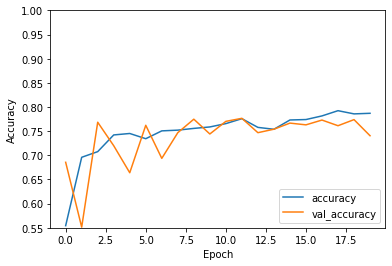

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.7405405640602112
0.5301761031150818


# MODEL EVALUATION

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

35/35 - 1s - loss: 0.5302 - accuracy: 0.7405 - 737ms/epoch - 21ms/step


## MODEL WITH 45 LAYERS

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(45, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(45, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(45, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 45)        1260      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 45)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 45)        18270     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 45)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 45)          18270     
                                                                 
Total params: 37,800
Trainable params: 37,800
Non-trai

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(45, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 45)        1260      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 45)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 45)        18270     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 45)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 45)          18270     
                                                                 
 flatten_1 (Flatten)         (None, 3645)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 9s 78ms/step - loss: 0.7352 - accuracy: 0.5766 - val_loss: 0.6129 - val_accuracy: 0.6577
Epoch 2/10
104/104 [==============================] - 8s 77ms/step - loss: 0.6005 - accuracy: 0.6929 - val_loss: 0.6159 - val_accuracy: 0.6568
Epoch 3/10
104/104 [==============================] - 8s 77ms/step - loss: 0.5835 - accuracy: 0.7076 - val_loss: 0.5428 - val_accuracy: 0.7279
Epoch 4/10
104/104 [==============================] - 8s 76ms/step - loss: 0.6117 - accuracy: 0.6935 - val_loss: 0.5485 - val_accuracy: 0.7207
Epoch 5/10
104/104 [==============================] - 8s 79ms/step - loss: 0.5556 - accuracy: 0.7341 - val_loss: 0.5281 - val_accuracy: 0.7577
Epoch 6/10
104/104 [==============================] - 9s 81ms/step - loss: 0.5336 - accuracy: 0.7416 - val_loss: 0.5086 - val_accuracy: 0.7613
Epoch 7/10
104/104 [==============================] - 8s 77ms/step - loss: 0.5307 - accuracy: 0.7464 - val_loss: 0.5015 - val_accuracy: 0.7667

35/35 - 1s - loss: 0.5018 - accuracy: 0.7721 - 668ms/epoch - 19ms/step


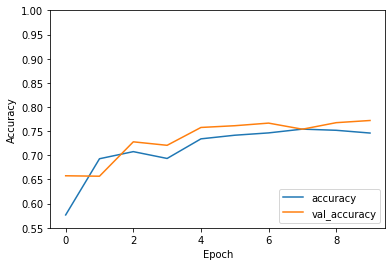

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

#MODEL EVALUATION

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

35/35 - 1s - loss: 0.5018 - accuracy: 0.7721 - 685ms/epoch - 20ms/step


In [ ]:
print(test_acc)
print(test_loss)

0.7720720767974854
0.5018366575241089


## MODEL WITH LAYERS 35

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(35, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(35, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(35, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 35)        980       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 35)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 35)        11060     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 35)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 35)          11060     
                                                                 
Total params: 23,100
Trainable params: 23,100
Non-trai

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 35)        980       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 35)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 35)        11060     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 35)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 35)          11060     
                                                                 
 flatten_2 (Flatten)         (None, 2835)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 7s 67ms/step - loss: 0.7632 - accuracy: 0.5294 - val_loss: 0.7378 - val_accuracy: 0.5189
Epoch 2/10
104/104 [==============================] - 7s 69ms/step - loss: 0.6134 - accuracy: 0.6773 - val_loss: 0.5768 - val_accuracy: 0.6964
Epoch 3/10
104/104 [==============================] - 7s 68ms/step - loss: 0.5914 - accuracy: 0.7004 - val_loss: 0.7518 - val_accuracy: 0.5982
Epoch 4/10
104/104 [==============================] - 7s 67ms/step - loss: 0.5759 - accuracy: 0.7052 - val_loss: 0.5462 - val_accuracy: 0.7315
Epoch 5/10
104/104 [==============================] - 7s 68ms/step - loss: 0.5496 - accuracy: 0.7374 - val_loss: 0.5104 - val_accuracy: 0.7550
Epoch 6/10
104/104 [==============================] - 7s 68ms/step - loss: 0.5473 - accuracy: 0.7326 - val_loss: 0.5351 - val_accuracy: 0.7640
Epoch 7/10
104/104 [==============================] - 7s 68ms/step - loss: 0.5310 - accuracy: 0.7464 - val_loss: 0.5233 - val_accuracy: 0.7396

35/35 - 1s - loss: 0.5064 - accuracy: 0.7640 - 606ms/epoch - 17ms/step


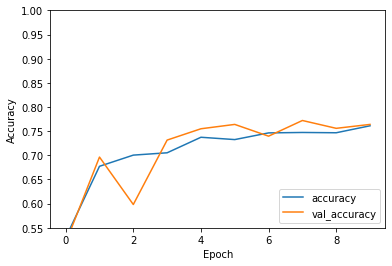

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

#MODEL EVALUATION

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

35/35 - 1s - loss: 0.5064 - accuracy: 0.7640 - 635ms/epoch - 18ms/step


In [ ]:
print(test_acc)
print(test_loss)

0.7639639377593994
0.5063785314559937


## MODEL WITH LAYERS 25

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(25, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(25, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(25, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 25)        700       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 25)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 25)        5650      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 25)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 9, 25)          5650      
                                                                 
Total params: 12,000
Trainable params: 12,000
Non-trai

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 25)        700       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 25)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 25)        5650      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 25)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 9, 25)          5650      
                                                                 
 flatten_3 (Flatten)         (None, 2025)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 6s 48ms/step - loss: 0.7432 - accuracy: 0.5141 - val_loss: 0.6827 - val_accuracy: 0.5189
Epoch 2/10
104/104 [==============================] - 5s 46ms/step - loss: 0.6515 - accuracy: 0.6187 - val_loss: 0.6018 - val_accuracy: 0.6712
Epoch 3/10
104/104 [==============================] - 5s 46ms/step - loss: 0.5861 - accuracy: 0.6992 - val_loss: 0.5610 - val_accuracy: 0.7270
Epoch 4/10
104/104 [==============================] - 5s 46ms/step - loss: 0.5913 - accuracy: 0.6950 - val_loss: 0.5532 - val_accuracy: 0.7324
Epoch 5/10
104/104 [==============================] - 5s 46ms/step - loss: 0.5579 - accuracy: 0.7224 - val_loss: 0.5495 - val_accuracy: 0.7216
Epoch 6/10
104/104 [==============================] - 5s 46ms/step - loss: 0.5491 - accuracy: 0.7341 - val_loss: 0.7825 - val_accuracy: 0.6261
Epoch 7/10
104/104 [==============================] - 5s 46ms/step - loss: 0.5633 - accuracy: 0.7197 - val_loss: 0.5455 - val_accuracy: 0.7604

35/35 - 0s - loss: 0.5043 - accuracy: 0.7595 - 451ms/epoch - 13ms/step


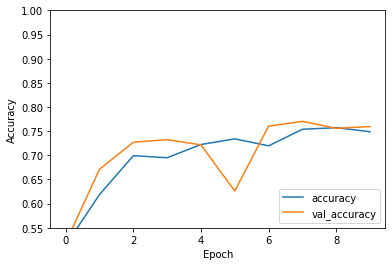

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

# MODEL EVALUATION

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

35/35 - 0s - loss: 0.5043 - accuracy: 0.7595 - 454ms/epoch - 13ms/step


In [ ]:
print(test_acc)
print(test_loss)

0.7594594359397888
0.5042839646339417


##Fourth MODEL WITH LAYERS 15

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(15, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(15, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(15, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 15)        420       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 15)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 15)        2040      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 11, 11, 15)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 9, 15)          2040      
                                                                 
Total params: 4,500
Trainable params: 4,500
Non-traina

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 15)        420       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 15)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 15)        2040      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 11, 11, 15)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 9, 15)          2040      
                                                                 
 flatten_4 (Flatten)         (None, 1215)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 4s 38ms/step - loss: 0.9835 - accuracy: 0.4997 - val_loss: 0.7056 - val_accuracy: 0.5036
Epoch 2/10
104/104 [==============================] - 4s 38ms/step - loss: 0.7258 - accuracy: 0.5312 - val_loss: 0.7794 - val_accuracy: 0.4811
Epoch 3/10
104/104 [==============================] - 4s 38ms/step - loss: 0.6693 - accuracy: 0.5938 - val_loss: 0.6478 - val_accuracy: 0.6072
Epoch 4/10
104/104 [==============================] - 4s 38ms/step - loss: 0.6012 - accuracy: 0.6869 - val_loss: 0.5647 - val_accuracy: 0.7162
Epoch 5/10
104/104 [==============================] - 4s 38ms/step - loss: 0.5792 - accuracy: 0.7118 - val_loss: 0.5408 - val_accuracy: 0.7514
Epoch 6/10
104/104 [==============================] - 4s 38ms/step - loss: 0.5762 - accuracy: 0.7127 - val_loss: 0.6037 - val_accuracy: 0.6721
Epoch 7/10
104/104 [==============================] - 4s 38ms/step - loss: 0.5621 - accuracy: 0.7160 - val_loss: 0.5971 - val_accuracy: 0.7000

35/35 - 0s - loss: 0.5412 - accuracy: 0.7459 - 410ms/epoch - 12ms/step


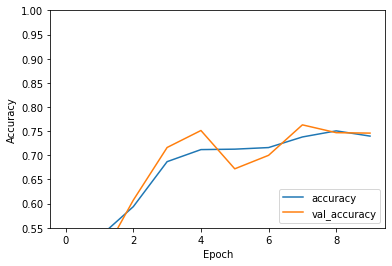

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.745945930480957
0.5411990880966187


## MODEL WITH LAYERS 10

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(10, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(10, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 10)        280       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 22, 22, 10)        910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 11, 11, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 10)          910       
                                                                 
Total params: 2,100
Trainable params: 2,100
Non-train

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 10)        280       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 22, 22, 10)        910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 11, 11, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 10)          910       
                                                                 
 flatten_5 (Flatten)         (None, 810)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 4s 32ms/step - loss: 1.1606 - accuracy: 0.5177 - val_loss: 0.6665 - val_accuracy: 0.5865
Epoch 2/10
104/104 [==============================] - 3s 31ms/step - loss: 0.6268 - accuracy: 0.6499 - val_loss: 0.5764 - val_accuracy: 0.7126
Epoch 3/10
104/104 [==============================] - 3s 31ms/step - loss: 0.6082 - accuracy: 0.6896 - val_loss: 0.6021 - val_accuracy: 0.6748
Epoch 4/10
104/104 [==============================] - 3s 31ms/step - loss: 0.6068 - accuracy: 0.6854 - val_loss: 0.5441 - val_accuracy: 0.7297
Epoch 5/10
104/104 [==============================] - 3s 31ms/step - loss: 0.5631 - accuracy: 0.7206 - val_loss: 0.5361 - val_accuracy: 0.7568
Epoch 6/10
104/104 [==============================] - 3s 31ms/step - loss: 0.5540 - accuracy: 0.7260 - val_loss: 0.5541 - val_accuracy: 0.7306
Epoch 7/10
104/104 [==============================] - 3s 31ms/step - loss: 0.5503 - accuracy: 0.7350 - val_loss: 0.5244 - val_accuracy: 0.7550

35/35 - 0s - loss: 0.5079 - accuracy: 0.7667 - 374ms/epoch - 11ms/step


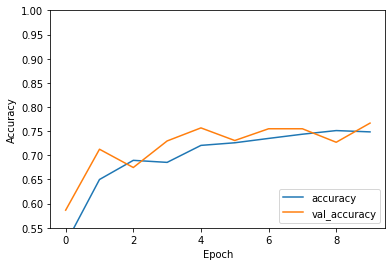

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.7666666507720947
0.5078940391540527


## MODEL WITH LAYERS 5

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(5, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(5, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(5, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 5)         140       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 22, 22, 5)         230       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 11, 11, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 9, 9, 5)           230       
                                                                 
Total params: 600
Trainable params: 600
Non-trainable

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 5)         140       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 22, 22, 5)         230       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 11, 11, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 9, 9, 5)           230       
                                                                 
 flatten_6 (Flatten)         (None, 405)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 4s 29ms/step - loss: 1.1602 - accuracy: 0.4826 - val_loss: 0.7043 - val_accuracy: 0.4928
Epoch 2/10
104/104 [==============================] - 3s 27ms/step - loss: 0.7046 - accuracy: 0.5150 - val_loss: 0.7243 - val_accuracy: 0.5180
Epoch 3/10
104/104 [==============================] - 3s 27ms/step - loss: 0.6988 - accuracy: 0.5183 - val_loss: 0.6886 - val_accuracy: 0.5360
Epoch 4/10
104/104 [==============================] - 3s 27ms/step - loss: 0.6895 - accuracy: 0.5379 - val_loss: 0.6831 - val_accuracy: 0.5928
Epoch 5/10
104/104 [==============================] - 3s 27ms/step - loss: 0.6898 - accuracy: 0.5526 - val_loss: 0.7008 - val_accuracy: 0.4847
Epoch 6/10
104/104 [==============================] - 3s 27ms/step - loss: 0.6797 - accuracy: 0.5718 - val_loss: 0.6716 - val_accuracy: 0.5505
Epoch 7/10
104/104 [==============================] - 3s 28ms/step - loss: 0.6474 - accuracy: 0.6262 - val_loss: 0.6068 - val_accuracy: 0.6712

35/35 - 0s - loss: 0.5642 - accuracy: 0.7261 - 385ms/epoch - 11ms/step


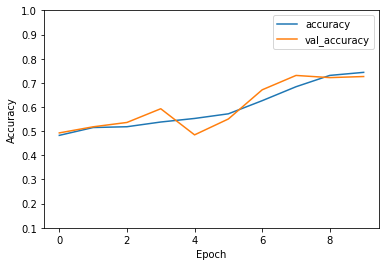

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.7261261343955994
0.5642030239105225


##Trainning WITH LAYERS 70




In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(70, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(70, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(70, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 48, 48, 70)        1960      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 22, 22, 70)        44170     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 11, 11, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 9, 9, 70)          44170     
                                                                 
Total params: 90,300
Trainable params: 90,300
Non-tra

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(70, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 48, 48, 70)        1960      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 22, 22, 70)        44170     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 11, 11, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 9, 9, 70)          44170     
                                                                 
 flatten_7 (Flatten)         (None, 5670)            

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 14s 131ms/step - loss: 0.7579 - accuracy: 0.4982 - val_loss: 0.6889 - val_accuracy: 0.4856
Epoch 2/10
104/104 [==============================] - 13s 128ms/step - loss: 0.6690 - accuracy: 0.5977 - val_loss: 0.6495 - val_accuracy: 0.6207
Epoch 3/10
104/104 [==============================] - 13s 128ms/step - loss: 0.5649 - accuracy: 0.7227 - val_loss: 0.5152 - val_accuracy: 0.7577
Epoch 4/10
104/104 [==============================] - 13s 127ms/step - loss: 0.5622 - accuracy: 0.7236 - val_loss: 0.5421 - val_accuracy: 0.7459
Epoch 5/10
104/104 [==============================] - 13s 127ms/step - loss: 0.5427 - accuracy: 0.7398 - val_loss: 0.4991 - val_accuracy: 0.7595
Epoch 6/10
104/104 [==============================] - 13s 127ms/step - loss: 0.5462 - accuracy: 0.7383 - val_loss: 0.4937 - val_accuracy: 0.7802
Epoch 7/10
104/104 [==============================] - 13s 127ms/step - loss: 0.5140 - accuracy: 0.7554 - val_loss: 0.4926 - val_ac

35/35 - 1s - loss: 0.4881 - accuracy: 0.7793 - 1s/epoch - 30ms/step


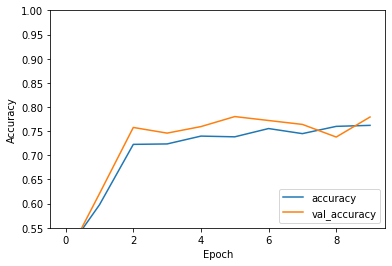

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.7792792916297913
0.48812437057495117


##CONVOLUTIONAL MODEL WITH LAYERS 75

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(75, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(75, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(75, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 75)        2100      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 22, 22, 75)        50700     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 11, 11, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 9, 9, 75)          50700     
                                                                 
Total params: 103,500
Trainable params: 103,500
Non-t

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 75)        2100      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 22, 22, 75)        50700     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 11, 11, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 9, 9, 75)          50700     
                                                                 
 flatten_8 (Flatten)         (None, 6075)            

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 15s 143ms/step - loss: 0.7289 - accuracy: 0.5388 - val_loss: 0.6729 - val_accuracy: 0.5486
Epoch 2/10
104/104 [==============================] - 15s 143ms/step - loss: 0.5948 - accuracy: 0.6932 - val_loss: 0.6508 - val_accuracy: 0.6270
Epoch 3/10
104/104 [==============================] - 15s 142ms/step - loss: 0.6000 - accuracy: 0.7028 - val_loss: 0.5345 - val_accuracy: 0.7369
Epoch 4/10
104/104 [==============================] - 15s 141ms/step - loss: 0.5453 - accuracy: 0.7326 - val_loss: 0.5586 - val_accuracy: 0.7387
Epoch 5/10
104/104 [==============================] - 15s 142ms/step - loss: 0.5412 - accuracy: 0.7413 - val_loss: 0.5256 - val_accuracy: 0.7468
Epoch 6/10
104/104 [==============================] - 15s 142ms/step - loss: 0.5418 - accuracy: 0.7404 - val_loss: 0.5479 - val_accuracy: 0.7171
Epoch 7/10
104/104 [==============================] - 15s 141ms/step - loss: 0.5229 - accuracy: 0.7533 - val_loss: 0.4878 - val_ac

35/35 - 1s - loss: 0.4759 - accuracy: 0.7811 - 1s/epoch - 33ms/step


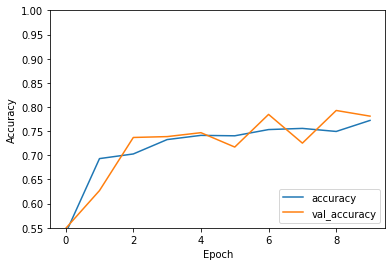

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.7810810804367065
0.47587570548057556


#CONVOLUTIONAL MODEL WITH LAYERS *80*

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(80, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(80, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(80, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 48, 48, 80)        2240      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 24, 24, 80)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 22, 22, 80)        57680     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 11, 11, 80)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 9, 9, 80)          57680     
                                                                 
Total params: 117,600
Trainable params: 117,600
Non-t

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 48, 48, 80)        2240      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 24, 24, 80)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 22, 22, 80)        57680     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 11, 11, 80)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 9, 9, 80)          57680     
                                                                 
 flatten_9 (Flatten)         (None, 6480)            

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(xtrain, ytrain, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
139/139 [==============================] - 20s 141ms/step - loss: 3.1121 - accuracy: 0.6020 - val_loss: 2.0897 - val_accuracy: 0.5189
Epoch 2/10
139/139 [==============================] - 19s 139ms/step - loss: 0.6386 - accuracy: 0.6473 - val_loss: 2.0354 - val_accuracy: 0.5189
Epoch 3/10
139/139 [==============================] - 19s 139ms/step - loss: 0.5917 - accuracy: 0.7021 - val_loss: 2.0108 - val_accuracy: 0.5189
Epoch 4/10
139/139 [==============================] - 19s 139ms/step - loss: 0.5732 - accuracy: 0.7156 - val_loss: 2.0022 - val_accuracy: 0.5189
Epoch 5/10
139/139 [==============================] - 19s 140ms/step - loss: 0.5496 - accuracy: 0.7298 - val_loss: 1.9409 - val_accuracy: 0.5189
Epoch 6/10
139/139 [==============================] - 19s 140ms/step - loss: 0.5781 - accuracy: 0.7032 - val_loss: 1.9272 - val_accuracy: 0.5189
Epoch 7/10
139/139 [==============================] - 19s 139ms/step - loss: 0.5503 - accuracy: 0.7359 - val_loss: 1.8796 - val_ac

35/35 - 1s - loss: 1.7562 - accuracy: 0.5189 - 1s/epoch - 32ms/step


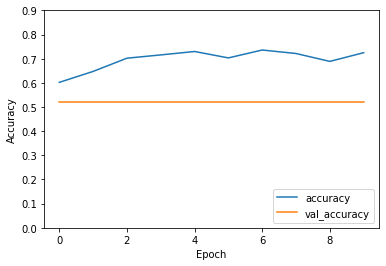

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.9])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.5189189314842224
1.7561975717544556


##CONVOLUTIONAL MODEL WITH LAYERS 85

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(85, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(85, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(85, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 48, 48, 85)        2380      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 85)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 22, 22, 85)        65110     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 11, 11, 85)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 9, 9, 85)          65110     
                                                                 
Total params: 132,600
Trainable params: 132,600
Non-t

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(85, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 48, 48, 85)        2380      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 85)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 22, 22, 85)        65110     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 11, 11, 85)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 9, 9, 85)          65110     
                                                                 
 flatten_10 (Flatten)        (None, 6885)            

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(xtrain, ytrain, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
139/139 [==============================] - 23s 161ms/step - loss: 5.0409 - accuracy: 0.6135 - val_loss: 2.1305 - val_accuracy: 0.5189
Epoch 2/10
139/139 [==============================] - 22s 162ms/step - loss: 0.6076 - accuracy: 0.6860 - val_loss: 2.1005 - val_accuracy: 0.5189
Epoch 3/10
139/139 [==============================] - 22s 162ms/step - loss: 0.6039 - accuracy: 0.6842 - val_loss: 2.0794 - val_accuracy: 0.5189
Epoch 4/10
139/139 [==============================] - 22s 161ms/step - loss: 0.5788 - accuracy: 0.7140 - val_loss: 2.0448 - val_accuracy: 0.5189
Epoch 5/10
139/139 [==============================] - 22s 161ms/step - loss: 0.5564 - accuracy: 0.7266 - val_loss: 2.0126 - val_accuracy: 0.5189
Epoch 6/10
139/139 [==============================] - 22s 161ms/step - loss: 0.5272 - accuracy: 0.7498 - val_loss: 1.9988 - val_accuracy: 0.5189
Epoch 7/10
139/139 [==============================] - 22s 161ms/step - loss: 0.5264 - accuracy: 0.7485 - val_loss: 1.9874 - val_ac

35/35 - 1s - loss: 1.8783 - accuracy: 0.5189 - 1s/epoch - 38ms/step


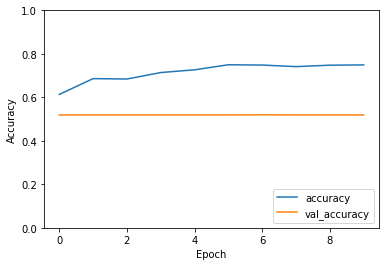

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.5189189314842224
1.8782519102096558


##CONVOLUTIONAL MODEL WITH LAYERS 90

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(90, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(90, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(90, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 48, 48, 90)        2520      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 24, 24, 90)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 22, 22, 90)        72990     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 11, 11, 90)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 9, 9, 90)          72990     
                                                                 
Total params: 148,500
Trainable params: 148,500
Non-t

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(90, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 48, 48, 90)        2520      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 24, 24, 90)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 22, 22, 90)        72990     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 11, 11, 90)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 9, 9, 90)          72990     
                                                                 
 flatten_11 (Flatten)        (None, 7290)            

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 19s 175ms/step - loss: 0.7538 - accuracy: 0.5463 - val_loss: 0.6089 - val_accuracy: 0.7036
Epoch 2/10
104/104 [==============================] - 18s 174ms/step - loss: 0.6069 - accuracy: 0.6788 - val_loss: 0.5662 - val_accuracy: 0.7018
Epoch 3/10
104/104 [==============================] - 18s 174ms/step - loss: 0.5626 - accuracy: 0.7175 - val_loss: 0.5634 - val_accuracy: 0.7703
Epoch 4/10
104/104 [==============================] - 18s 174ms/step - loss: 0.5395 - accuracy: 0.7440 - val_loss: 0.5085 - val_accuracy: 0.7622
Epoch 5/10
104/104 [==============================] - 18s 173ms/step - loss: 0.5288 - accuracy: 0.7452 - val_loss: 0.5319 - val_accuracy: 0.7486
Epoch 6/10
104/104 [==============================] - 18s 173ms/step - loss: 0.5334 - accuracy: 0.7416 - val_loss: 0.5106 - val_accuracy: 0.7559
Epoch 7/10
104/104 [==============================] - 18s 173ms/step - loss: 0.5347 - accuracy: 0.7461 - val_loss: 0.5297 - val_ac

35/35 - 1s - loss: 0.4905 - accuracy: 0.7838 - 1s/epoch - 41ms/step


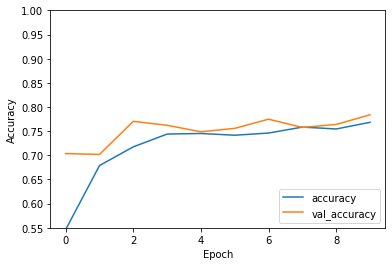

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.7837837934494019
0.4904504716396332


##CONVOLUTIONAL MODEL WITH LAYERS 95

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(95, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(95, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(95, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 48, 48, 95)        2660      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 95)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 22, 22, 95)        81320     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 11, 11, 95)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 9, 9, 95)          81320     
                                                                 
Total params: 165,300
Trainable params: 165,300
Non-t

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(95, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 48, 48, 95)        2660      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 95)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 22, 22, 95)        81320     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 11, 11, 95)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 9, 9, 95)          81320     
                                                                 
 flatten_12 (Flatten)        (None, 7695)            

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 20s 182ms/step - loss: 0.7214 - accuracy: 0.5607 - val_loss: 0.6677 - val_accuracy: 0.5225
Epoch 2/10
104/104 [==============================] - 19s 186ms/step - loss: 0.5970 - accuracy: 0.6917 - val_loss: 0.5521 - val_accuracy: 0.7514
Epoch 3/10
104/104 [==============================] - 20s 190ms/step - loss: 0.5547 - accuracy: 0.7302 - val_loss: 0.5935 - val_accuracy: 0.6622
Epoch 4/10
104/104 [==============================] - 20s 188ms/step - loss: 0.5793 - accuracy: 0.7103 - val_loss: 0.5625 - val_accuracy: 0.7045
Epoch 5/10
104/104 [==============================] - 19s 186ms/step - loss: 0.5524 - accuracy: 0.7350 - val_loss: 0.5965 - val_accuracy: 0.6838
Epoch 6/10
104/104 [==============================] - 20s 194ms/step - loss: 0.5281 - accuracy: 0.7527 - val_loss: 0.5694 - val_accuracy: 0.7090
Epoch 7/10
104/104 [==============================] - 21s 198ms/step - loss: 0.5197 - accuracy: 0.7470 - val_loss: 0.5436 - val_ac

35/35 - 2s - loss: 0.4863 - accuracy: 0.7775 - 2s/epoch - 50ms/step


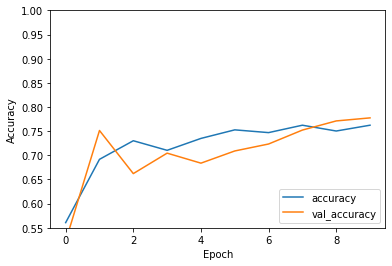

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

0.777477502822876
0.48633500933647156


##CONVOLUTIONAL MODEL WITH LAYERS 100

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
model = Sequential()

model.add(layers.Conv2D(100, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(100, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(100, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 48, 48, 100)       2800      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 24, 24, 100)      0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 22, 22, 100)       90100     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 11, 11, 100)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 9, 9, 100)         90100     
                                                                 
Total params: 183,000
Trainable params: 183,000
Non-t

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(9))

In [ ]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 48, 48, 100)       2800      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 24, 24, 100)      0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 22, 22, 100)       90100     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 11, 11, 100)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 9, 9, 100)         90100     
                                                                 
 flatten_13 (Flatten)        (None, 8100)            

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
104/104 [==============================] - 23s 212ms/step - loss: 0.7319 - accuracy: 0.5165 - val_loss: 0.5999 - val_accuracy: 0.6829
Epoch 2/10
104/104 [==============================] - 21s 206ms/step - loss: 0.6208 - accuracy: 0.6749 - val_loss: 0.6134 - val_accuracy: 0.6559
Epoch 3/10
104/104 [==============================] - 21s 203ms/step - loss: 0.5944 - accuracy: 0.6905 - val_loss: 0.5282 - val_accuracy: 0.7450
Epoch 4/10
104/104 [==============================] - 21s 202ms/step - loss: 0.5585 - accuracy: 0.7257 - val_loss: 0.5227 - val_accuracy: 0.7640
Epoch 5/10
104/104 [==============================] - 21s 201ms/step - loss: 0.5495 - accuracy: 0.7347 - val_loss: 0.6540 - val_accuracy: 0.6270
Epoch 6/10
104/104 [==============================] - 21s 203ms/step - loss: 0.5352 - accuracy: 0.7509 - val_loss: 0.4982 - val_accuracy: 0.7622
Epoch 7/10
104/104 [==============================] - 21s 202ms/step - loss: 0.5269 - accuracy: 0.7500 - val_loss: 0.5025 - val_ac

35/35 - 2s - loss: 0.4949 - accuracy: 0.7793 - 2s/epoch - 49ms/step


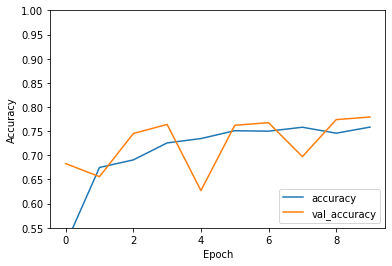

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)
print(test_loss)

#TRANSFERRED LEARNING

In [ ]:
import os
import zipfile
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator



In [ ]:
import pathlib
X= np.load("/content/X.npy")
Y= np.load("/content/Y.npy")
y = Y.reshape(Y.shape[0],1)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255


In [ ]:
model = Sequential()
conv_base = VGG19(weights='imagenet',include_top=False,input_shape=(50, 50, 3))

model.add(conv_base)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()


80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_14 (Flatten)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 32)                16416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,040,833
Trainable params: 20,040,833
Non-trainable params: 0
__________________________________________

In [ ]:
from tensorflow.keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
          loss='binary_crossentropy',
          metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
batch_size = 32
epochs = 100

datagen = ImageDataGenerator(zoom_range=0.2,      
                             rotation_range=0.2,
                             fill_mode="nearest",
                             horizontal_flip = True,
                             vertical_flip=True)

datagen.fit(X_train)

history = model.fit(datagen.flow(X_train,y_train,batch_size = batch_size),
                               steps_per_epoch=(len(X_train)/batch_size),epochs=epochs,
                               validation_data=(X_test,y_test),validation_steps=(len(X_test)/batch_size))

Epoch 1/100
130/130 [==============================] - 346s 3s/step - loss: 0.6958 - accuracy: 0.5591 - val_loss: 0.5887 - val_accuracy: 0.6820
Epoch 2/100
130/130 [==============================] - 335s 3s/step - loss: 0.6134 - accuracy: 0.6846 - val_loss: 0.5790 - val_accuracy: 0.7217
Epoch 3/100
130/130 [==============================] - 339s 3s/step - loss: 0.5864 - accuracy: 0.7168 - val_loss: 0.5439 - val_accuracy: 0.7585
Epoch 4/100
130/130 [==============================] - 336s 3s/step - loss: 0.5585 - accuracy: 0.7380 - val_loss: 0.5210 - val_accuracy: 0.7404
Epoch 5/100
130/130 [==============================] - 331s 3s/step - loss: 0.5431 - accuracy: 0.7474 - val_loss: 0.7028 - val_accuracy: 0.6655
Epoch 6/100
130/130 [==============================] - 333s 3s/step - loss: 0.5268 - accuracy: 0.7536 - val_loss: 0.6244 - val_accuracy: 0.7224
Epoch 7/100
130/130 [==============================] - 331s 3s/step - loss: 0.5117 - accuracy: 0.7673 - val_loss: 0.4874 - val_accuracy:

#MODEL EVALUATION


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.55, 1])
plt.legend(loc='lower right')
plt.title("model Accuracy")

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
def plot_learning_curve(history, epoch):
  epoch_range = range (1,epoch+1)
  plt.plot( epoch_range,history.history["accuracy"])
  plt.plot(epoch_range,history.history["val_accuracy"])
  plt.title("model Accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Train","val"], loc = "upper left")
  plt.show()

  # plot training & validation loss
  plt.plot(epoch_range,history.history["loss"])
  plt.plot(epoch_range, history.history["val_loss"])
  plt.title("model loss")
  plt.ylabel("loss")
  plt.xlabel("Epoch")
  plt.legend(["Train","val"], loc = "upper left")
  plt.show()

In [ ]:
history.history

In [ ]:
plot_learning_curve(history, epochs)

In [ ]:
y_pred = model.predict(X_test)
y_pred= (y_pred >0.5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42, stratify=y)
y_train[:10]

# Confusion Metrics

In [ ]:
import sklearn.metrics as metrics
conf = metrics.confusion_matrix(y_test, y_pred)
conf

In [ ]:
print(conf)

In [ ]:
classes = ["IDC(-)" ,"IDC(+)"]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
plt.title('vgg19 - Loss')
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "val loss")
plt.legend()
plt.show()

plt.figure()
plt.title('vgg19 - Accuracy')
plt.plot(history.history["accuracy"], label = "train accuracy")
plt.plot(history.history["val_accuracy"], label = "val accuracy")
plt.legend()
plt.show()


In [ ]:
from sklearn import metrics
loss,accuracy = model.evaluate(X_test,y_test)
plt.plot(history.history['accuracy'], label='accuracy')
y_pred = model.predict(X_test)